# Receiver Denoising Experiment

In this notebook, I aim to simulate simple communication between 1 tx and 1 rx with noise inbetween and train an AutoEncoderDecoder to denoise it.

In [45]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense

import math
from pyphysim.modulators.fundamental import BPSK, QAM, Modulator
from pyphysim.simulations import Result, SimulationResults, SimulationRunner
from pyphysim.util.conversion import dB2Linear
from pyphysim.util.misc import randn_c, count_bit_errors
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from scipy.fft import fft, ifft

# Simple denoising

low-pass filter and moving avg are not typically used in this because modulated signals contain information at various waveband and low-pass filter would probably delete those info out.

so we use wavelet transform and adaptive filtering.


In [46]:
import pywt

def wavelet_denoise(data, wavelet, level):
    coeff = pywt.wavedec(data, wavelet, level=level)
    threshold = np.sqrt(2*np.log(len(data))) * np.median(np.abs(coeff[-level])) / 0.6745
    coeff[1:] = (pywt.threshold(i, value=threshold, mode='soft') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet)

# Data Generation and Preprocessing Functions

In [47]:
# since tensorflow don't handle complex number well
# we make several functions for

def complex_to_mag_phase(data):
    # Calculate magnitude and phase for each complex number
    magnitude = np.abs(data)  # Magnitude
    phase = np.angle(data)    # Phase

    # Reshape the arrays and combine them
    combined = np.concatenate([magnitude.reshape(-1, 1), phase.reshape(-1, 1)], axis=1).reshape(data.shape[0], data.shape[1]*2)
    return combined

def mag_phase_to_complex(data):
    magnitude = data[:, 0]
    phase = data[:, 1]
    complex_data = magnitude * (np.cos(phase) + 1j * np.sin(phase))
    return complex_data


def complex_to_real_modified(data):
    # this will transform complex number to [real1, img1, real2, img2, etc]
    shape = data.shape
    real_part = data.real.reshape(shape[0], -1, 1)
    imag_part = data.imag.reshape(shape[0], -1, 1)
    combined = np.concatenate([real_part, imag_part], axis=2)
    return combined.reshape(shape[0], -1)

def real_to_complex_modified(data):
    # this will transform [real1, img1, real2, img2, etc] back to [complex1, complex2, ...]
    shape = data.shape
    reshaped = data.reshape(shape[0], -1, 2)
    complex_data = reshaped[:, :, 0] + 1j * reshaped[:, :, 1]
    return complex_data

def reshape_for_chunks(data, chunk_size):
    shape = data.shape
    reshaped = data.reshape((shape[0]*(shape[1]//chunk_size)), chunk_size)
    return reshaped

def reshape_back_from_chunks(data, total_samples, num_symbols):
    return data.reshape(total_samples, num_symbols)

def complex_to_real(data):
    # this case will transform complex number to [real1, real2, img1, img2]
    real_part = data.real
    imag_part = data.imag
    return np.concatenate([real_part, imag_part], axis=1)

def real_to_complex(data):
    # this case will transform real number to [real1, real2, img1, img2] -> [complex numbers]
    real_part = data[:, :data.shape[1] // 2]
    imag_part = data[:, data.shape[1] // 2:]
    return real_part + 1j * imag_part

def generate_data(modulator, snr_db, num_symbols):
    data, modulated_data = generate_noisy_qam_signal(modulator, num_symbols)
    noisy_data =  add_noise_to_signal(modulated_data, snr_db)
    # noisy_data = modulated_data + noise_level * randn_c(num_symbols)
    return data, modulated_data, noisy_data

def generate_noisy_qam_signal(modulator, num_symbols):
    """ Generate QAM modulated signal """
    data = np.random.randint(0, modulator.M, num_symbols)
    modulated_data = modulator.modulate(data)
    return data, modulated_data

def add_noise_to_signal(signal, snr_db):
    """ Add Gaussian noise to a signal to achieve the given SNR in dB """
    signal_power = np.mean(np.abs(signal)**2)
    snr_linear = 10 ** (snr_db / 10)  # Convert SNR from dB to linear
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    noisy_signal = signal + noise
    return noisy_signal


In [48]:
# ber symbols calculation for evaluation
def calculate_ber(original_data, received_data, modulator):
    demodulated_data = modulator.demodulate(received_data)
    bit_errors = count_bit_errors(original_data, demodulated_data)
    total_bits = original_data.size * np.log2(modulator.M)
    return bit_errors / total_bits


def symbol_errors(original_data, demodulated_data):
    return sum(demodulated_data != original_data)


# Experiment with real/img preprocesing - no chunking


In [57]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Parameters
modulator = QAM(16)
snr_db = 7  # SNR in dB
num_symbols = 1000

# Generate Datasets
training = [generate_data(modulator, snr_db, num_symbols) for _ in range(5000)]
train_unmodulated_y, training_y, training_x  = zip(*training)
train_unmodulated_y = np.array(train_unmodulated_y)
training_x = np.array(training_x)
training_y = np.array(training_y)
training_x_real = complex_to_real_modified(training_x)
training_y_real = complex_to_real_modified(training_y)
training_x_real_norm = scaler.fit_transform(training_x_real)
training_y_real_norm = scaler.transform(training_y_real)


testing = [generate_data(modulator, snr_db, num_symbols) for _ in range(2500)]
testing_unmodulated_y, testing_y, testing_x = zip(*testing)
testing_unmodulated_y = np.array(testing_unmodulated_y)
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)
testing_x_real = complex_to_real_modified(testing_x)
testing_y_real = complex_to_real_modified(testing_y)
testing_x_real_norm = scaler.fit_transform(testing_x_real)
testing_y_real_norm = scaler.transform(testing_y_real)




In [58]:
class CustomAutoencoder(Model):
    def __init__(self, input_shape):
        super(CustomAutoencoder, self).__init__()
        initializer = tf.keras.initializers.HeUniform(1)
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_shape,)),
            Dense(1024, activation='relu', kernel_initializer=initializer),
            Dense(1024, activation='relu', kernel_initializer=initializer),
        ])
        # Bottleneck
        self.bottleneck = Dense(512, activation='relu', kernel_initializer=initializer)
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            Dense(1024, activation='relu', kernel_initializer=initializer),
            Dense(1024, activation='relu', kernel_initializer=initializer),
            Dense(input_shape, activation='tanh', kernel_initializer=initializer)
        ])

    def call(self, inputs, training=None, mask=None):
        # Encoder
        x = self.encoder(inputs)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        x = self.decoder(x)
        return x

Epoch 1/100
16/16 [==============================] - 1s 59ms/step - loss: 0.3316 - val_loss: 0.3179
Epoch 2/100
16/16 [==============================] - 1s 42ms/step - loss: 0.3175 - val_loss: 0.3178
Epoch 3/100
16/16 [==============================] - 1s 43ms/step - loss: 0.3166 - val_loss: 0.3177
Epoch 4/100
16/16 [==============================] - 1s 43ms/step - loss: 0.3150 - val_loss: 0.3174
Epoch 5/100
16/16 [==============================] - 1s 45ms/step - loss: 0.3127 - val_loss: 0.3170
Epoch 6/100
16/16 [==============================] - 1s 44ms/step - loss: 0.3099 - val_loss: 0.3164
Epoch 7/100
16/16 [==============================] - 1s 47ms/step - loss: 0.3070 - val_loss: 0.3160
Epoch 8/100
16/16 [==============================] - 1s 47ms/step - loss: 0.3043 - val_loss: 0.3157
Epoch 9/100
16/16 [==============================] - 1s 50ms/step - loss: 0.3018 - val_loss: 0.3156
Epoch 10/100
16/16 [==============================] - 1s 42ms/step - loss: 0.2994 - val_loss: 0.3155

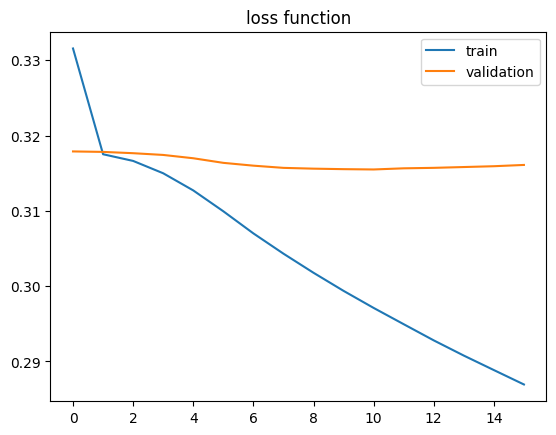

In [59]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
callbacks = [early_stopping_monitor]
# Define the autoencoder architecture
# input_signal = tf.keras.layers.Input(shape=(2 * num_symbols,))
# encoded = tf.keras.layers.Dense(128, activation='relu')(input_signal)  # Increased size
# decoded = tf.keras.layers.Dense(2 * num_symbols, activation='tanh')(encoded)  # Output size doubled
# autoencoder = tf.keras.models.Model(inputs=input_signal, outputs=decoded)
autoencoder = CustomAutoencoder(training_x_real_norm.shape[1])
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
# Compile and train the model
autoencoder.compile(optimizer=optimizer,
                    loss='mean_absolute_error')
history = autoencoder.fit(training_x_real_norm,
                          training_y_real_norm,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=callbacks)

# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot losses
plt.figure()
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss function')
plt.legend()
plt.show(block=False)

In [60]:
# ber with autoencoder-decoder denoiser
ber_auto = []
pred_ys = autoencoder.predict(testing_x_real_norm)
pred_ys_imaginary = real_to_complex_modified(scaler.inverse_transform(pred_ys))
for i in range(testing_x_real.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        pred_ys_imaginary[i, :], modulator)
    ber_auto.append(ber)

# original ber
ber_ori = []
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        testing_x[i, :],
                        modulator)
    ber_ori.append(ber)

# ber with regular autoencoder-decoder denoiser

79/79 [==============================] - 1s 7ms/step


In [61]:
print(np.mean(ber_auto), np.mean(ber_ori))

0.49064140000000006 0.1193641


# Experiment with chunking and real/img preprocessing

In [62]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Parameters
modulator = QAM(16)
snr_db = 7
num_symbols = 1000
chunk_size = 2 # real and img only

# Generate Datasets
training = [generate_data(modulator, snr_db, num_symbols) for _ in range(5000)]
train_unmodulated_y, training_y, training_x  = zip(*training)
train_unmodulated_y = np.array(train_unmodulated_y)
training_x = np.array(training_x)
training_y = np.array(training_y)
training_x_real = complex_to_real_modified(training_x)
training_y_real = complex_to_real_modified(training_y)
training_x_real_chunked = reshape_for_chunks(training_x_real, chunk_size)
training_y_real_chunked = reshape_for_chunks(training_y_real, chunk_size)
training_x_real_chunked_norm = scaler.fit_transform(training_x_real_chunked)
training_y_real_chunked_norm = scaler.transform(training_y_real_chunked)


testing = [generate_data(modulator, snr_db, num_symbols) for _ in range(2500)]
testing_unmodulated_y, testing_y, testing_x = zip(*testing)
testing_unmodulated_y = np.array(testing_unmodulated_y)
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)
testing_x_real = complex_to_real_modified(testing_x)
testing_y_real = complex_to_real_modified(testing_y)
testing_x_real_chunked = reshape_for_chunks(testing_x_real, chunk_size)
testing_y_real_chunked = reshape_for_chunks(testing_y_real, chunk_size)
testing_x_real_chunked_norm = scaler.fit_transform(testing_x_real_chunked)
testing_y_real_chunked_norm = scaler.transform(testing_y_real_chunked)




In [63]:
class CustomAutoencoder(Model):
    def __init__(self, input_shape):
        super(CustomAutoencoder, self).__init__()
        initializer = tf.keras.initializers.HeUniform(1)
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_shape,)),
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(32, activation='relu', kernel_initializer=initializer),
        ])
        # Bottleneck
        self.bottleneck = Dense(16, activation='relu', kernel_initializer=initializer)
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(input_shape, activation='tanh', kernel_initializer=initializer)
        ])

    def call(self, inputs, training=None, mask=None):
        # Encoder
        x = self.encoder(inputs)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        x = self.decoder(x)
        return x

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
callbacks = [early_stopping_monitor]
# Define the autoencoder architecture
# input_signal = tf.keras.layers.Input(shape=(2 * num_symbols,))
# encoded = tf.keras.layers.Dense(128, activation='relu')(input_signal)  # Increased size
# decoded = tf.keras.layers.Dense(2 * num_symbols, activation='tanh')(encoded)  # Output size doubled
# autoencoder = tf.keras.models.Model(inputs=input_signal, outputs=decoded)
autoencoder = CustomAutoencoder(chunk_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
# Compile and train the model
autoencoder.compile(optimizer=optimizer,
                    loss='mean_absolute_error')
history = autoencoder.fit(training_x_real_chunked_norm,
                          training_y_real_chunked_norm,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=callbacks)

# plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot losses
plt.figure()
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss function')
plt.legend()
plt.show(block=False)

Epoch 1/100
15625/15625 [==============================] - 12s 744us/step - loss: 0.0673 - val_loss: 0.0643
Epoch 2/100
15625/15625 [==============================] - 11s 734us/step - loss: 0.0638 - val_loss: 0.0634
Epoch 3/100
15625/15625 [==============================] - 11s 730us/step - loss: 0.0634 - val_loss: 0.0632
Epoch 4/100
15625/15625 [==============================] - 12s 747us/step - loss: 0.0632 - val_loss: 0.0633
Epoch 5/100
15625/15625 [==============================] - 13s 815us/step - loss: 0.0630 - val_loss: 0.0631
Epoch 6/100
15625/15625 [==============================] - 12s 746us/step - loss: 0.0629 - val_loss: 0.0629
Epoch 7/100
15625/15625 [==============================] - 11s 736us/step - loss: 0.0628 - val_loss: 0.0631
Epoch 8/100
15625/15625 [==============================] - 12s 739us/step - loss: 0.0627 - val_loss: 0.0628
Epoch 9/100
 2552/15625 [===>..........................] - ETA: 8s - loss: 0.0626

In [ ]:
# ber with autoencoder-decoder denoiser
ber_auto = []
pred_ys = autoencoder.predict(testing_x_real_chunked_norm)
pred_ys_imaginary = real_to_complex_modified(scaler.inverse_transform(pred_ys)).reshape(testing_x_real.shape[0], num_symbols)
for i in range(testing_x_real.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        pred_ys_imaginary[i, :], modulator)
    ber_auto.append(ber)

In [ ]:
# original ber
ber_ori = []
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        testing_x[i, :],
                        modulator)
    ber_ori.append(ber)

# ber with regular autoencoder-decoder denoiser


In [ ]:
print(np.mean(ber_auto), np.mean(ber_ori))

# Experiment with chunking and mag/phase preprocessing

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Parameters
modulator = QAM(16)
snr_db = 8
num_symbols = 1000
chunk_size = 2 # real and img only

# Generate Datasets
training = [generate_data(modulator, snr_db, num_symbols) for _ in range(5000)]
train_unmodulated_y, training_y, training_x  = zip(*training)
train_unmodulated_y = np.array(train_unmodulated_y)
training_x = np.array(training_x)
training_y = np.array(training_y)
training_x_real = complex_to_mag_phase(training_x)
training_y_real = complex_to_mag_phase(training_y)
training_x_real_chunked = reshape_for_chunks(training_x_real, chunk_size)
training_y_real_chunked = reshape_for_chunks(training_y_real, chunk_size)
training_x_real_chunked_norm = scaler.fit_transform(training_x_real_chunked)
training_y_real_chunked_norm = scaler.transform(training_y_real_chunked)


testing = [generate_data(modulator, snr_db, num_symbols) for _ in range(2500)]
testing_unmodulated_y, testing_y, testing_x = zip(*testing)
testing_unmodulated_y = np.array(testing_unmodulated_y)
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)
testing_x_real = complex_to_mag_phase(testing_x)
testing_y_real = complex_to_mag_phase(testing_y)
testing_x_real_chunked = reshape_for_chunks(testing_x_real, chunk_size)
testing_y_real_chunked = reshape_for_chunks(testing_y_real, chunk_size)
testing_x_real_chunked_norm = scaler.fit_transform(testing_x_real_chunked)
testing_y_real_chunked_norm = scaler.transform(testing_y_real_chunked)

In [ ]:

class CustomAutoencoder(Model):
    def __init__(self, input_shape):
        super(CustomAutoencoder, self).__init__()
        initializer = tf.keras.initializers.HeUniform(1)
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            Input(shape=(input_shape,)),
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(32, activation='relu', kernel_initializer=initializer),
        ])
        # Bottleneck
        self.bottleneck = Dense(16, activation='relu', kernel_initializer=initializer)
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dense(input_shape, activation='tanh', kernel_initializer=initializer)
        ])

    def call(self, inputs, training=None, mask=None):
        # Encoder
        x = self.encoder(inputs)
        # Bottleneck
        x = self.bottleneck(x)
        # Decoder
        x = self.decoder(x)
        return x


In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
callbacks = [early_stopping_monitor]
# Define the autoencoder architecture
# input_signal = tf.keras.layers.Input(shape=(2 * num_symbols,))
# encoded = tf.keras.layers.Dense(128, activation='relu')(input_signal)  # Increased size
# decoded = tf.keras.layers.Dense(2 * num_symbols, activation='tanh')(encoded)  # Output size doubled
# autoencoder = tf.keras.models.Model(inputs=input_signal, outputs=decoded)
autoencoder = CustomAutoencoder(chunk_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
# Compile and train the model
autoencoder.compile(optimizer=optimizer,
                    loss='mean_absolute_error')
history = autoencoder.fit(training_x_real_chunked_norm,
                          training_y_real_chunked_norm,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=callbacks)

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot losses
plt.figure()
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss function')
plt.legend()
plt.show(block=False)

In [ ]:
# ber with autoencoder-decoder denoiser
ber_auto = []
pred_ys = autoencoder.predict(testing_x_real_chunked_norm)
pred_ys_imaginary = mag_phase_to_complex(scaler.inverse_transform(pred_ys)).reshape(testing_x_real.shape[0], num_symbols)
for i in range(testing_x_real.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        pred_ys_imaginary[i, :], modulator)
    ber_auto.append(ber)

In [ ]:
print("Mean bit error rate from denoising with auto-encoder", np.mean(ber_auto))

In [ ]:
# original ber
ber_ori = []
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        testing_x[i, :],
                        modulator)
    ber_ori.append(ber)



In [ ]:
print("Mean bit error rate from not doing anything", np.mean(ber_ori))

In [ ]:
# simple denoising method
# probably need to play around more with algorithm and parameters.
ber_wave = []
denoisd_wavelet_data = wavelet_denoise(testing_x, 'db1', level=3)
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        denoisd_wavelet_data[i, :],
                        modulator)
    ber_wave.append(ber)

In [ ]:
print(np.mean(ber_ori), np.mean(ber_auto), np.mean(ber_wave))

# Noise Based on Random Noise Model
Basically the unpack function


In [25]:
import random

def generate_data_noisy(modulator,  num_symbols):
    sinr_dBs = np.linspace(-5, 30, 8)
    EbN0_linear = dB2Linear(random.choice(sinr_dBs))
    # Note that when M=2 BPSK modulation will be used, while other values will use QAM
    M =  [2, 4, 16, 64, 256] # since QAM is used
    snr_linear = EbN0_linear * math.log2(random.choice(M))
    noise_power = 1 / snr_linear
    n = math.sqrt(noise_power) * randn_c(num_symbols)
    data = np.random.randint(0, modulator.M, num_symbols)
    modulated_data = modulator.modulate(data)
    noisy_data = modulated_data + n
    return data, modulated_data, noisy_data

In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Parameters
modulator = QAM(16)
noise_level = 0.6
num_symbols = 1000
chunk_size = 2 # real and img only

# Generate Datasets
training = [generate_data_noisy(modulator, num_symbols) for _ in range(5000)]
train_unmodulated_y, training_y, training_x  = zip(*training)
train_unmodulated_y = np.array(train_unmodulated_y)
training_x = np.array(training_x)
training_y = np.array(training_y)
training_x_real = complex_to_mag_phase(training_x)
training_y_real = complex_to_mag_phase(training_y)
training_x_real_chunked = reshape_for_chunks(training_x_real, chunk_size)
training_y_real_chunked = reshape_for_chunks(training_y_real, chunk_size)
training_x_real_chunked_norm = scaler.fit_transform(training_x_real_chunked)
training_y_real_chunked_norm = scaler.transform(training_y_real_chunked)


testing = [generate_data_noisy(modulator, num_symbols) for _ in range(2500)]
testing_unmodulated_y, testing_y, testing_x = zip(*testing)
testing_unmodulated_y = np.array(testing_unmodulated_y)
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)
testing_x_real = complex_to_mag_phase(testing_x)
testing_y_real = complex_to_mag_phase(testing_y)
testing_x_real_chunked = reshape_for_chunks(testing_x_real, chunk_size)
testing_y_real_chunked = reshape_for_chunks(testing_y_real, chunk_size)
testing_x_real_chunked_norm = scaler.fit_transform(testing_x_real_chunked)
testing_y_real_chunked_norm = scaler.transform(testing_y_real_chunked)

Epoch 1/100
15625/15625 [==============================] - 12s 738us/step - loss: 0.0567 - val_loss: 0.0505
Epoch 2/100
15625/15625 [==============================] - 11s 688us/step - loss: 0.0514 - val_loss: 0.0490
Epoch 3/100
15625/15625 [==============================] - 11s 681us/step - loss: 0.0507 - val_loss: 0.0490
Epoch 4/100
15625/15625 [==============================] - 11s 732us/step - loss: 0.0503 - val_loss: 0.0484
Epoch 5/100
15625/15625 [==============================] - 11s 683us/step - loss: 0.0500 - val_loss: 0.0485
Epoch 6/100
15625/15625 [==============================] - 11s 680us/step - loss: 0.0497 - val_loss: 0.0476
Epoch 7/100
15625/15625 [==============================] - 11s 692us/step - loss: 0.0494 - val_loss: 0.0470
Epoch 8/100
15625/15625 [==============================] - 11s 690us/step - loss: 0.0491 - val_loss: 0.0471
Epoch 9/100
15625/15625 [==============================] - 11s 672us/step - loss: 0.0489 - val_loss: 0.0470
Epoch 10/100
15625/15625 [==

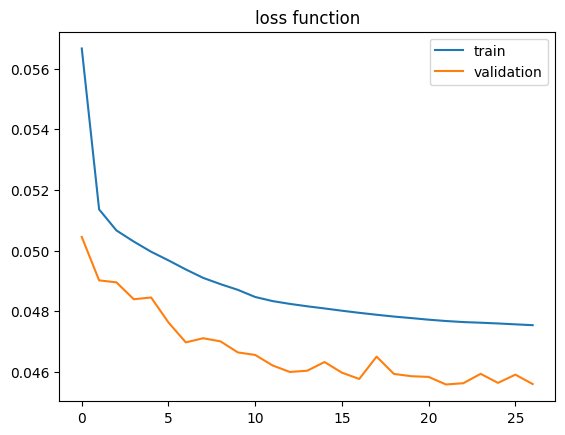

In [40]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
callbacks = [early_stopping_monitor]
# Define the autoencoder architecture
# input_signal = tf.keras.layers.Input(shape=(2 * num_symbols,))
# encoded = tf.keras.layers.Dense(128, activation='relu')(input_signal)  # Increased size
# decoded = tf.keras.layers.Dense(2 * num_symbols, activation='tanh')(encoded)  # Output size doubled
# autoencoder = tf.keras.models.Model(inputs=input_signal, outputs=decoded)
autoencoder = CustomAutoencoder(chunk_size)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)
# Compile and train the model
autoencoder.compile(optimizer=optimizer,
                    loss='mean_absolute_error')
history = autoencoder.fit(training_x_real_chunked_norm,
                          training_y_real_chunked_norm,
                          epochs=100,
                          batch_size=256,
                          validation_split=0.2,
                          callbacks=callbacks)

loss = history.history['loss']
val_loss = history.history['val_loss']

# plot losses
plt.figure()
plt.plot(loss, label='train')
plt.plot(val_loss, label='validation')
plt.title('loss function')
plt.legend()
plt.show(block=False)

In [41]:
# original ber
ber_ori = []
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        testing_x[i, :],
                        modulator)
    ber_ori.append(ber)



In [42]:
# ber with autoencoder-decoder denoiser
ber_auto = []
pred_ys = autoencoder.predict(testing_x_real_chunked_norm)
pred_ys_imaginary = mag_phase_to_complex(scaler.inverse_transform(pred_ys)).reshape(testing_x_real.shape[0], num_symbols)
for i in range(testing_x_real.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        pred_ys_imaginary[i, :], modulator)
    ber_auto.append(ber)

78125/78125 [==============================] - 20s 252us/step


In [43]:
# simple denoising method
# probably need to play around more with algorithm and parameters.
ber_wave = []
denoisd_wavelet_data = wavelet_denoise(testing_x, 'db1', level=3)
for i in range(testing_x.shape[0]):
    ber = calculate_ber(testing_unmodulated_y[i],
                        denoisd_wavelet_data[i, :],
                        modulator)
    ber_wave.append(ber)

In [44]:
print(np.mean(ber_ori), np.mean(ber_auto), np.mean(ber_wave))

0.0662859 0.0679509 0.43823019999999996


# Rayleigh AWGN simulation training
copied from the Pyphysim library - eventual work is to put in denoising methods in this to run simulation comparison.


In [ ]:
class RayleighOrAwgnSimulatorWithDenoiser(SimulationRunner):

    def __init__(self, SINR_dB_values, simulate_with_rayleigh=False):
        # If simulate_with_rayleigh is false only AWGN is used
        super().__init__()

        self._simulate_with_rayleigh = simulate_with_rayleigh

        # Add the simulation parameters to the `params` attribute.
        self.params.add('EbN0_db', SINR_dB_values)
        self.params.set_unpack_parameter('EbN0_db')

        # Note that when M=2 BPSK modulation will be used, while other values will use QAM
        self.params.add("M", [2, 4, 16, 64, 256])
        self.params.set_unpack_parameter('M')

        # Number of times the `_run_simulation` method will run when `simulate` method is called.
        # We are using a value 100 times larger than before, but the simulation will not take
        # 100 times the previous elapsed time to finish thanks to the implementation of the
        # `_keep_going` method that will allow us to skip many of these iterations for low EbN0 values
        self.rep_max = 50000

        # Number of symbols generated for this realization
        self.num_symbols = 1000

        # Used in the implementation of `_keep_going` method. This is the maximum numbers of symbol
        # errors we allow before `_run_simulation` is stoped for a given configuration
        self.max_symbol_errors = 1. / 300. * self.num_symbols * self.rep_max

        # Set a nice message for the progressbar
        self.progressbar_message = f"Simulating for {self.params.get_num_unpacked_variations()} configurations"

        self.update_progress_function_style = "text1"  # "ipython"

    def generate_dataset(self, num_samples):
        # Since EbN0_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = self.params['EbN0_db']
        M = self.params['M']

        modulator = BPSK() if M == 2 else QAM(M)

        # Find the noise power from the EbN0 value (in dB)
        EbN0_linear = dB2Linear(sinr_dB)
        snr_linear = EbN0_linear * math.log2(M)
        noise_power = 1 / snr_linear
        modulated_samples = []
        noisy_modulated_samples = []
        for i in range(num_samples):
            data = np.random.randint(0, modulator.M, size=self.num_symbols)
            modulated_data = modulator.modulate(data)
            n = math.sqrt(noise_power) * randn_c(self.num_symbols)
            if self._simulate_with_rayleigh:
                # Rayleigh channel
                h = randn_c(modulated_data.size)

                # Receive the corrupted data
                received_data = h * modulated_data + n

                # Equalization
                received_data /= h

            else:
                # Receive the corrupted data
                received_data = modulated_data + n

            # Demodulate the received data and compute the number of symbol errors
            demodulated_data = modulator.demodulate(received_data)
            modulated_samples.append(modulated_data)
            noisy_modulated_samples.append(received_data)
            # symbol_errors = sum(demodulated_data != data)
            #
            # num_bit_errors = count_bit_errors(data, demodulated_data)
        return noisy_modulated_samples, modulated_samples


    def _keep_going(self, current_params, current_sim_results, current_rep):
        # Note that we have added a "symbol_errors" result in `_run_simulation` to use here

        # Get the last value in the "symbol_errors" results list, which corresponds to the current configuration
        cumulated_symbol_errors \
            = current_sim_results['symbol_errors'][-1].get_result()
        return cumulated_symbol_errors < self.max_symbol_errors


    def _run_simulation(self, current_parameters):
        # Since EbN0_db is an "unpacked parameter" a single value is passed to `_run_simulation`.
        # We can get the current value as below
        sinr_dB = current_parameters['EbN0_db']
        M = current_parameters['M']

        modulator = BPSK() if M == 2 else QAM(M)

        # Find the noise power from the EbN0 value (in dB)
        EbN0_linear = dB2Linear(sinr_dB)
        snr_linear = EbN0_linear * math.log2(M)
        noise_power = 1 / snr_linear

        # Generate random transmit data and modulate it
        data = np.random.randint(0, modulator.M, size=self.num_symbols)
        modulated_data = modulator.modulate(data)

        # Noise vector
        n = math.sqrt(noise_power) * randn_c(self.num_symbols)

        if self._simulate_with_rayleigh:
            # Rayleigh channel
            h = randn_c(modulated_data.size)

            # Receive the corrupted data
            received_data = h * modulated_data + n

            # Equalization
            received_data /= h

        else:
            # Receive the corrupted data
            received_data = modulated_data + n

        # Demodulate the received data and compute the number of symbol errors
        demodulated_data = modulator.demodulate(received_data)
        symbol_errors = sum(demodulated_data != data)

        num_bit_errors = count_bit_errors(data, demodulated_data)

        # Create a SimulationResults object and save the symbol error rate.
        # Note that the symbol error rate is given by the number of symbol errors divided by the number of
        # transmited symbols. We want to combine the symbol error rate for the many calls of `_run_simulation`.
        # Thus, we choose `Result.RATIOTYPE` as the "update_type". See the documentation of the `Result` class
        # for more about it.
        simResults = SimulationResults()
        simResults.add_new_result("symbol_error_rate",
                                  Result.RATIOTYPE,
                                  value=symbol_errors,
                                  total=self.num_symbols)
        simResults.add_new_result("symbol_errors",
                                  Result.SUMTYPE,
                                  value=symbol_errors)
        simResults.add_new_result("num_bit_errors",
                                  Result.SUMTYPE,
                                  value=num_bit_errors)
        simResults.add_new_result("bit_error_rate",
                                  Result.RATIOTYPE,
                                  value=num_bit_errors,
                                  total=int(np.log2(modulator.M)) * data.size)
        return simResults

In [ ]:
EbN0_db_awgn = np.linspace(-5, 30, 8)

runner_awgn = RayleighOrAwgnSimulatorWithDenoiser(EbN0_db_awgn,
                                                  simulate_with_rayleigh=False)
runner_awgn.set_results_filename("qam_awgn")
print("Simulation parameters:", runner_awgn.params)

# runner_awgn.simulate_in_parallel()
runner_awgn.simulate()
print(runner_awgn.elapsed_time)